In [19]:
def sub_parts_old(c):
    """
    For a list c = [1,2,0], return
                  [[0,0,0],
                   [1,0,0],
                   [0,1,0],
                   [1,1,0],
                   [0,2,0]]
    """
    #TODO: It might be possible to make this faster with memoization -- but
    # not much faster, since the set of subparts is *very large*.
    # Better to just use the Weyl group tbh.
    if len(c) == 1:
        return [[x] for x in range(c[0])]

    if c[0] == 0:
        return [[0] + y for y in sub_parts(c[1:])]

    d = sub_parts(c[1:])
    g = sub_parts([c[0]-1]+c[1:])+[[c[0]]+y for y in sub_parts(c[1:])]+[[c[0]-1]+c[1:]]
    return g

In [26]:
import numpy as np

In [30]:
#Timing tests
import time


rnd_list = np.random.randint(1,50,size=(100,3))


start = time.time()
_ = [sub_parts(x) for x in rnd_list]
end = time.time()
print(end - start)

start = time.time()
_ = [sub_parts_old(x) for x in rnd_list]
end = time.time()
print(end - start)



5.65797591209
1.60357689857


In [33]:
# Example of use:
# CartanMatrix([[2,-3],[-3,2]]).rm(depth=25)


def sub_parts(c):
    """
    For a list c = [1,2,0], return
                  [[0,0,0],
                   [1,0,0],
                   [0,1,0],
                   [1,1,0],
                   [0,2,0]]
    """
    #TODO: Make it faster
    # Maybe can use partition algorithms somehow?
    # http://doc.sagemath.org/html/en/reference/combinat/sage/combinat/partition.html
    return [list(y) for y in cartesian_product([range(x+1) for x in c])][:-1]

def common_divisors(l):
    # Returns the common divisors of a list l of integers >= 0.
    return divisors(gcd(l))

def all_lists(l,s):
    #return all lists with length l and sum s
    if l == 1:
        return [[s]]
    to_return = []
    for i in range(s+1):
        to_return = to_return + [[i]+x for x in all_lists(l-1,s-i)]
    return to_return

def mult(self, height=10):
    # TODO: This version is cleaner and faster, but has a BUG (can be verified using A3)
    # It's probably just a silly arithmetic typo, I will fix ASAP!

    # Returns the root multiplicities of a Cartan matrix self
    # Recall that if beta is a root, then mult(beta) = mult(-beta)
    # So we only have to check positive roots.

    # Peterson's recurrence formula:
    # For beta a positive root,
    # B(beta, 2rho - beta)c_beta = sum_{alpha+gamma=beta} B(alpha, gamma)c_alphac_gamma
    # where B is the Killing form, rho is the is the functional that sends the coroot
    # hat alpha_i to a_ii/2, and c(beta) = sum_n mult(beta/n)/n.

    self.multiplicities = {}
    self.c = {}
    self.c[tuple([0, 0, 0])] = 0
    mat = self.symmetrized_matrix() # TODO: Does this need to be a dense_matrix?
    dim = mat.nrows()

    def two_rho(beta):
        # The functional rho which appears in Peterson's recurrence formula
        # TODO: This is probably a BUG if mat is not symmetric. Fix it.
        return -2*sum(beta)

    def B(a, b):
        # The Killing form of mat
        # TODO: This is probably a BUG if mat is not symmetric. Fix it.
        return a * mat * b

    # Initialize the dict of root multiplicities so we can start the induction.
    for root in all_lists(dim, 1):
        # Iterate over all positive simple roots of mat.
        self.multiplicities[tuple(root)] = 1
        self.c[tuple(root)] = 1

    # Now do the inductive step.
    for h in range(2, height + 1):
        for root in all_lists(dim, h):
            # Iterate over all positive elements of the root lattice of mat,
            # with height ( = ell^1 norm) h >= 2.
            RHS = 0 # Right-hand side of Peterson's recurrence formula
            root = vector(root)

            for subroot in sub_parts(list(root)):
                # Sum over subroots
                # TODO: We don't actually need to sum over the subroots because the
                # action of the Weyl group preserves multiplicities, and hence c.
                # So this could be greatly sped up.
                subroot = vector(subroot)
                if subroot == 0:
                    continue
                RHS = RHS + B(subroot, root - subroot)*self.c[tuple(subroot)]*self.c[tuple(root - subroot)]

            # The factor which appears in the left-hand side of Peterson's recurrence formula
            # TODO: This is probably a BUG if mat is not symmetric. Fix it.
            LHSFactor = B(root, root) + two_rho(root)
            if RHS == 0 and LHSFactor == 0:
                # Not a root
                self.multiplicities[tuple(root)] = 0
                self.c[tuple(root)] = 0
                continue

            # Compute c(root) - m(root)
            cRoot = 0
            for n in divisors(gcd(root)):
                if n != 1:
                    cRoot = cRoot + self.multiplicities[tuple(root/n)]/n
                    # TODO: Unsure if these vector-list castings are really necessary. I'm sleepy rn.

            self.multiplicities[tuple(root)] = RHS/LHSFactor - cRoot
            self.c[tuple(root)] = RHS/LHSFactor

    # Clean the root lattice, removing zero entries and replacing floats with ints
    notRoots = [] # Can't change the size of a dict during iteration
    for r in self.multiplicities:
        if self.multiplicities[r] == 0:
            notRoots.append(r)
    for r in notRoots:
        self.multiplicities.pop(r)
    return self.multiplicities
    return self.multiplicities



def rm(self,depth=5):
    # Returns the root multiplicities of a Cartan matrix self
    # Recall that if beta is a root, then mult(beta) = mult(-beta)
    # So we only have to check positive roots.
    R = self.root_system()
    L = R.root_lattice()
    S = L.simple_roots()
    self.multiplicities = {}
    D = self.symmetrized_matrix().dense_matrix()

    # Memoization of c
    cMemo = {}

    # Peterson's recurrence formula:
    # For beta a positive root,
    # B(beta, 2rho - beta)c_beta = sum_{alpha+gamma=beta} B(alpha, gamma)c_alphac_gamma
    # where B is the Killing form, rho is the is the functional that sends the coroot
    # hat alpha_i to a_ii/2, and c(beta) = sum_n mult(beta/n)/n.

    def c(beta):
        if beta in cMemo:
            return cMemo[beta]
        # The sum in Peterson's recurrence formula is formally infinite, but
        # since only when div|beta is the value nonzero, we only have to sum then.
        divisors = common_divisors(beta.dense_coefficient_list())
        c = 0
        for div in divisors:
            if beta/div in self.multiplicities:
                c = c + (float(1)/float(div))*self.multiplicities[beta/div]
        cMemo.update({beta: c})
        return c

    def two_rho(beta):
        return -2*sum(beta.dense_coefficient_list())

    def c_to_root(coeff):
        # Given coefficients, return the root they describe.
        #IT IS 0 INDEXED FOR INFINITE, 1 INDEXED FOR FINITE
        #THIS IS A BUG IN SAGE
        if 0 in S.keys():
            s = sum([S[int(x)]*int(coeff[x]) for x in range(len(coeff))])
        else:
            s = sum([S[int(x+1)]*int(coeff[x]) for x in range(len(coeff))])
        return s

    # Generates the root lattice up to the given depth.
    #Actually, it is SO much easier to induct on height...
    all_combs = []
    for l in [all_lists(len(S),x) for x in range(1,depth+1)]:
        all_combs = all_combs + l
    roots = [c_to_root(comb) for comb in all_combs]
    print(all_combs,roots)

    for r in roots:
        rd = r.dense_coefficient_list()
        if sum(rd) == 1: # If r is a simple root
            self.multiplicities[r] = 1
        else:
            a_o = 0
            for bp in [c_to_root(l) for l in sub_parts(rd) if sum(l) != 0]:
                # Sum over subroots. The number of subroots one has to sum
                # over could be greatly reduced because the action of the
                # Weyl group preserves multiplicities.
                # TODO this
                bpp = r-bp
                bpd = bp.dense_coefficient_list()
                bppd = bpp.dense_coefficient_list()
                a_o = a_o + vector(bppd)*D*vector(bpd)*c(bp)*c(bpp)
            b = vector((r).dense_coefficient_list())*D*vector((r).dense_coefficient_list()) + two_rho(r)

            c_o = 0
            for n in common_divisors(rd):
                if n != 1:
                    c_o = c_o + float(1)/float(n)*self.multiplicities[c_to_root(list(vector(rd)/n))]


            if a_o == 0 and b == 0:
                self.multiplicities[r] = 0
                continue
            self.multiplicities[r] = round(a_o/b-c_o)
            # prevent float division by 0
            # this could be avoided if we did arithmetic in Q

    # Clean the root lattice, removing zero entries and replacing floats with ints
    notRoots = [] # Can't change the size of a dict during iteration
    for r in self.multiplicities:
        self.multiplicities[r] = int(self.multiplicities[r])
        if self.multiplicities[r] == 0:
            notRoots.append(r)
    for r in notRoots:
        self.multiplicities.pop(r)
    return self.multiplicities

CartanMatrix.rm = rm
CartanMatrix.mult = mult



def CartanMatrixGenerator(dim):
    # Iterates over Cartan matrices of dimension dim
    # Create 2I_dim
    matrix = [[0 for i in range(dim)] for i in range(dim)]
    for i in range(dim):
        matrix[i][i] = 2
    order = 0 # By "order" of I mean the sum of -a_{ij}, i \neq j
    while true:
        # It might not be necessary to check *every* matrix, by checking
        # if a matrix is a direct sum. TODO this
        order = order + 1
        for vector in all_lists(dim * (dim - 1), order):
            k = 0
            for i in range(dim):
                for j in range(dim):
                    if i != j:
                        matrix[i][j] = -vector[k]
                        k = k + 1
            symmetricZeroes = true
            for i in range(dim):
                for j in range(dim): # This could be optimized...
                    if (matrix[i][j] == 0) and (matrix[j][i] != 0):
                        symmetricZeroes = false
            if symmetricZeroes:
                yield CartanMatrix(matrix)



def numerology(dim, count, dep):
    # Computes root multiplicities for dimension dim with depth dep, until count Kac-Moody algebras have been studied.
    with open('data.csv', 'a') as file:
        gen = CartanMatrixGenerator(dim)
        for i in range(count):
            kacmoody = next(gen)
            if kacmoody.is_symmetrizable():
                roots = kacmoody.rm(depth=dep)
                file.write(str(kacmoody) + "\n")
                print(str(kacmoody) + "\n")
                for root in roots:
                    try:
                        file.write(str(root) + ", " + str(roots[root]) + "\n")
                    except ZeroDivisionError as (errno, errstr):
                        print "ZeroDivisionError({0}): {1}".format(errno, strerror)
                file.write("\n\n")

In [34]:
bla = CartanMatrix([[2,-3],[-3,2]]).rm(depth=5)

([[0, 1], [1, 0], [0, 2], [1, 1], [2, 0], [0, 3], [1, 2], [2, 1], [3, 0], [0, 4], [1, 3], [2, 2], [3, 1], [4, 0], [0, 5], [1, 4], [2, 3], [3, 2], [4, 1], [5, 0]], [alpha[1], alpha[0], 2*alpha[1], alpha[0] + alpha[1], 2*alpha[0], 3*alpha[1], alpha[0] + 2*alpha[1], 2*alpha[0] + alpha[1], 3*alpha[0], 4*alpha[1], alpha[0] + 3*alpha[1], 2*alpha[0] + 2*alpha[1], 3*alpha[0] + alpha[1], 4*alpha[0], 5*alpha[1], alpha[0] + 4*alpha[1], 2*alpha[0] + 3*alpha[1], 3*alpha[0] + 2*alpha[1], 4*alpha[0] + alpha[1], 5*alpha[0]])


In [32]:
bla

{alpha[0]: 1,
 alpha[0] + alpha[1]: 1,
 alpha[0] + 2*alpha[1]: 1,
 alpha[0] + 3*alpha[1]: 1,
 2*alpha[0] + alpha[1]: 1,
 2*alpha[0] + 2*alpha[1]: 1,
 2*alpha[0] + 3*alpha[1]: 2,
 3*alpha[0] + alpha[1]: 1,
 3*alpha[0] + 2*alpha[1]: 2,
 alpha[1]: 1}

In [16]:
answer = bla

to_list = [[1,1],[2,2],[3,2],[3,3],[4,3],[4,4],[5,4],[6,4],[5,5],[6,5],[7,5],[6,6],[7,6],[8,6],[9,6],
          [7,7],[8,7],[9,7],[10,7],[8,8],[9,8]]
for x in to_list:
    for y in answer:
        if y.dense_coefficient_list() == x:
            print(x,answer[y])

([1, 1], 1)
([2, 2], 1)
([3, 2], 2)
([3, 3], 3)
([4, 3], 4)
([4, 4], 6)
([5, 4], 9)
([6, 4], 9)
([5, 5], 16)
([6, 5], 23)
([7, 5], 27)
([6, 6], 39)
([7, 6], 60)
([8, 6], 73)
([9, 6], 80)
([7, 7], 107)
([8, 7], 162)
([9, 7], 211)
([10, 7], 240)
([8, 8], 288)
([9, 8], 449)


In [224]:
pp = CartanMatrix([[2,-3],[-3,2]])

In [225]:
a = pp.rm(depth=40)

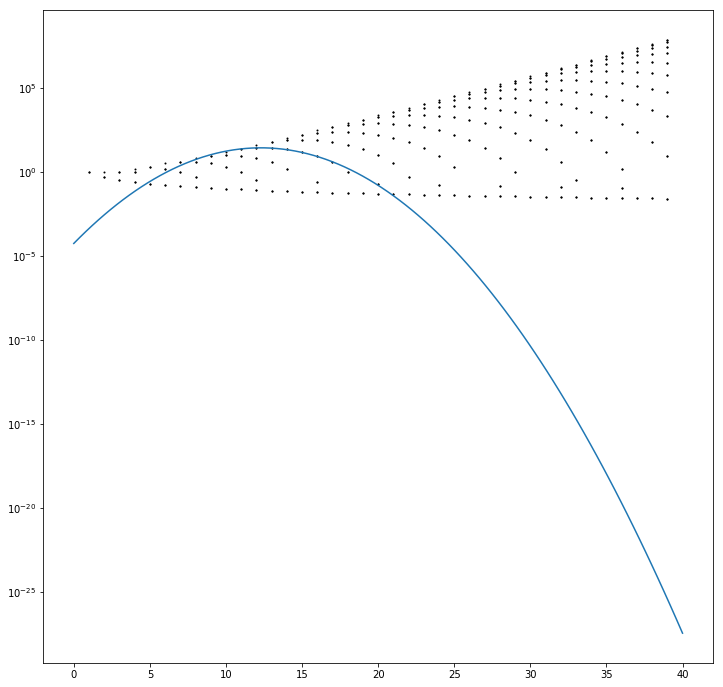

In [238]:
plt.figure(figsize=(12,12))
for x in pp.cMemo:
    y = x.dense_coefficient_list()
    plt.scatter(sum(y),pp.cMemo[x],color='black',s=1)

bins = np.linspace(0,40,100)
plt.plot(bins,np.e**(-0.08664391*bins**2+2.1308781*bins-9.80053823))
plt.gca().set_yscale('log')
plt.show()

In [237]:
#plt.figure(figsize=(12,12))
x_5 = []
y_5 = []
for x in pp.cMemo:
    y = x.dense_coefficient_list()
    if y[0] < y[1]:
        continue
    if pp.cMemo[x] == 0:
        continue
    if y[1] == 5:
        x_5.append(sum(y))
        y_5.append(pp.cMemo[x])
#    plt.scatter(sum(y),pp.cMemo[x],color='black',s=1)
#plt.gca().set_yscale('log')
#plt.show()

print(x_5,np.log(y_5))

np.polyfit(np.array(x_5),np.log(y_5),2)

([11, 10, 18, 17, 20, 15, 16, 14, 13, 12], array([ 3.13549422,  2.78501124,  0.        ,  1.38629436, -1.60943791,
        2.78501124,  2.19722458,  3.13549422,  3.29583687,  3.29583687]))


array([-0.08664391,  2.1308781 , -9.80053823])

In [25]:
R = CartanMatrix(["E",8]) #SL3`

In [204]:
R = CartanMatrix([[2,-3],[-3,2]])

In [205]:
answer = R.rm(depth=25)

In [74]:
answer = roots

In [182]:
answer = rms

In [206]:
to_list = [[1,1],[2,2],[3,2],[3,3],[4,3],[4,4],[5,4],[6,4],[5,5],[6,5],[7,5],[6,6],[7,6],[8,6],[9,6],
          [7,7],[8,7],[9,7],[10,7],[8,8],[9,8]]
for x in to_list:
    for y in answer:
        if y.dense_coefficient_list() == x:
            print(x,answer[y])

([1, 1], 1.0)
([2, 2], 1)
([3, 2], 2)
([3, 3], 3)
([4, 3], 4)
([4, 4], 6)
([5, 4], 9)
([6, 4], 9)
([5, 5], 16)
([6, 5], 23)
([7, 5], 27)
([6, 6], 39)
([7, 6], 60)
([8, 6], 73)
([9, 6], 80)
([7, 7], 107)
([8, 7], 162)
([9, 7], 211)
([10, 7], 240)
([8, 8], 288)
([9, 8], 449)


In [67]:
R = CartanMatrix([[2,-3],[-3,2]])

In [52]:
rms = c.rm(depth=40)

In [99]:
bang = [[0 for y in range(40)] for x in range(40)]
for x in rms:
    y = x.dense_coefficient_list()
    bang[y[0]-1][y[1]-1] = rms[x]%2

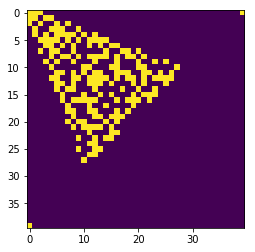

In [101]:
plt.imshow(bang)
plt.show()

In [78]:
c = CartanMatrix([[2,-2,0],[-2,2,-1],[0,-1,2]])
rms_2 = c.rm(depth=25)

In [79]:
def height(x):
    return sum(x.dense_coefficient_list())

mbh = []
for x in rms_2:
    while height(x) > len(mbh):
        mbh.append([])
    #print(len(mbh),height(x))
    mbh[height(x)-1].append(rms_2[x])

xs_2 = []
ys_2 = []

for x in range(len(mbh)):
    for y in mbh[x]:
        #print(x,y)
        xs_2.append(x+1)
        ys_2.append(y)
        #plt.scatter([x+1],[y],color='black')

In [132]:
c = CartanMatrix([[2,-6],[-6,2]])
rms = c.rm(depth=40)

In [133]:
def height(x):
    return sum(x.dense_coefficient_list())

mbh = []
for x in rms:
    while height(x) > len(mbh):
        mbh.append([])
    #print(len(mbh),height(x))
    mbh[height(x)-1].append(rms[x])

xs = []
ys = []

for x in range(len(mbh)):
    for y in mbh[x]:
        #print(x,y)
        xs.append(x+1)
        ys.append(y)
        #plt.scatter([x+1],[y],color='black')

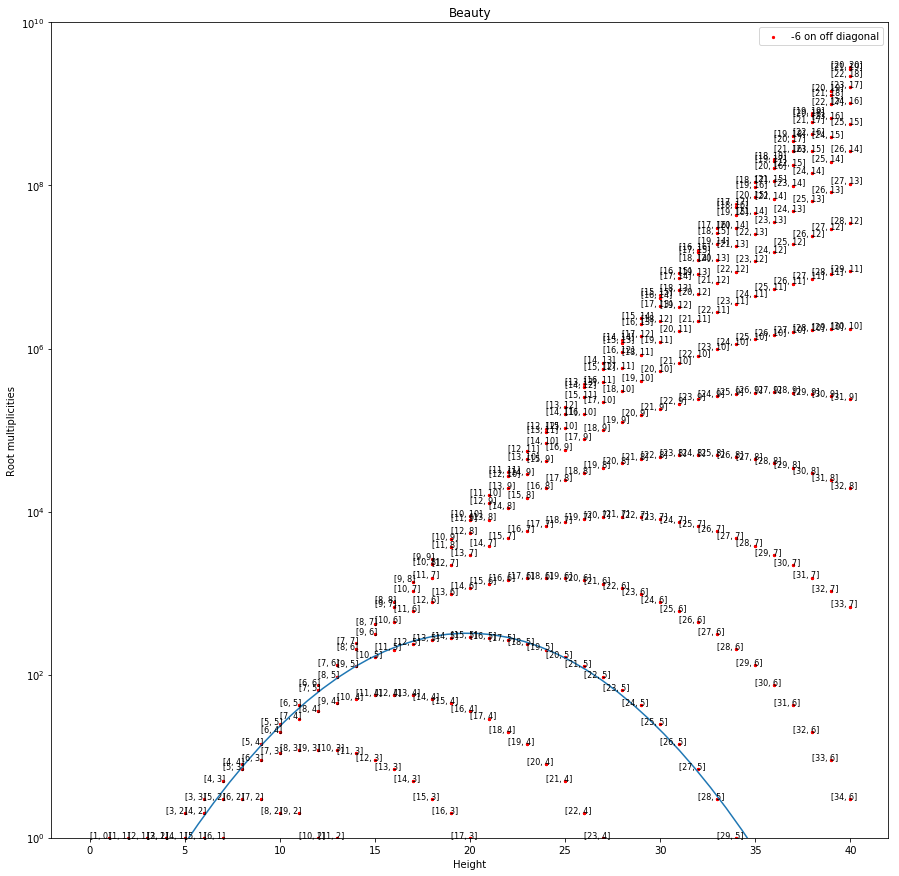

In [161]:
plt.figure(figsize=(15,15))

plt.scatter(xs,ys,color='red',label='-6 on off diagonal',s=5)

for x_i in range(len(rms)):
    x = rms.keys()[x_i]
    #print(x_i)
    y = x.dense_coefficient_list()
    if y[0] < y[1]:
        continue
    plt.text(height(x)-1, rms[x], x.dense_coefficient_list(),fontsize=8)
#plt.scatter(xs_2,ys_2,color='blue',label='-4 on off diagonal')
plt.gca().set_yscale('log')

#-0.02680887,  1.06678627, -4.83359503
bins = np.linspace(0,40)
plt.plot(bins,np.e**(-0.02680887*bins**2+1.06678627*bins-4.83359503))

plt.ylim(1,1e10)

plt.legend()
plt.ylabel("Root multiplicities")
plt.xlabel("Height")
plt.title("Beauty")
plt.show()

In [173]:
xs_5 = []
ys_5 = []

for x_i in range(len(rms)):
    x = rms.keys()[x_i]
    #print(x_i)
    y = x.dense_coefficient_list()
    if y[0] < y[1]:
        continue
        
    if y[1] == 5:
        xs_5.append(height(x))
        ys_5.append(rms[x])
    #plt.text(height(x)-1, rms[x], x.dense_coefficient_list(),fontsize=8)

In [207]:
rms = answer
xs_e = []
ys_e = []

for x_i in range(len(answer)):
    x = rms.keys()[x_i]
    #print(x_i)
    y = x.dense_coefficient_list()
    if y[0] == y[1]:
        xs_e.append(y[0])
        ys_e.append(rms[x])
    #plt.text(height(x)-1, rms[x], x.dense_coefficient_list(),fontsize=8)

In [172]:
np.polyfit(np.array(xs_5),np.log(ys_5),2)

array([-0.02680887,  1.06678627, -4.83359503])

In [31]:
import matplotlib.pyplot as plt

In [21]:
scatter_plot(np.array([range(len(mbh)),[sum(x)/len(x) for x in mbh[1:-1]]]))

ValueError: setting an array element with a sequence.

In [20]:
import numpy as np

In [77]:
numerology(Integer(2),Integer(10),Integer(50))

[ 2 -1]
[-1  2]

[ 2 -1]
[-2  2]

[ 2 -2]
[-1  2]



OverflowError: cannot convert float infinity to integer